# ukbb_cardiac predictions on kaggle

In [ ]:
from fastai.vision import *
import tensorflow.compat.v1 as tf
import altair as alt

In [ ]:
from misas.core import *

In [ ]:
img = lambda: open_image("example/kaggle/images/1-frame014-slice006.png")
trueMask = lambda: open_mask("example/kaggle/masks/1-frame014-slice006.png")

In [ ]:
class ukbb_model:
    def __init__(self, model_path):
        tf.disable_eager_execution()
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(f'{model_path}.meta')
        saver.restore(self.sess, model_path)
        
    def resize_for_input_(self, image):
        _, X, Y = image.shape
        image.crop_pad((int(math.ceil(X / 16.0)) * 16, int(math.ceil(Y / 16.0)) * 16), padding_mode="zeros")
        return image
    
    def image_to_input(self, image):
        img = image.clone()
        self.resize_for_input_(img)
        img_data = img.data[0]#.transpose(1,0).flip(dims=(1,))
        #img_data = rescale_intensity(img_data.numpy(), (1,99))
        img_data = np.expand_dims(img_data, 0)
        img_data = np.expand_dims(img_data, -1)
        return img_data
    
    def predict(self, image):
        image_data = self.image_to_input(image)
        preds, classes = self.sess.run(['prob:0', 'pred:0'],
                   feed_dict={'image:0': image_data, 'training:0': False})
        preds = np.squeeze(preds, 0)
        classes = ImageSegment(ByteTensor(classes))
        return classes, preds
        

In [ ]:
model = ukbb_model('example/kaggle/FCN_sa')
prep = model.resize_for_input_

INFO:tensorflow:Restoring parameters from example/kaggle/FCN_sa


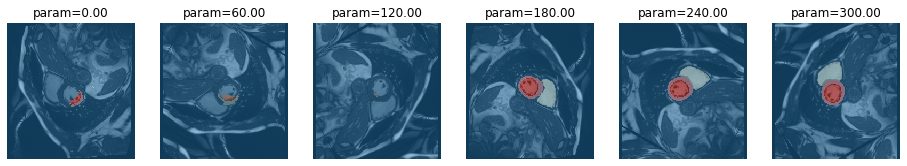

In [ ]:
plot_series(get_rotation_series(img(),model,prep_function=prep))

In [ ]:
results = eval_rotation_series(img(),trueMask(),model,prep_function=prep,components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['deg'],value_vars=['LV','MY']))
 .mark_line()
 .encode(
     x="deg",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)